In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

# Upload file Kaggle JSON
uploaded = files.upload()

!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d erhmrai/ecg-image-data

Saving kaggle.json to kaggle.json
100% 855M/858M [00:46<00:00, 21.6MB/s]
100% 858M/858M [00:46<00:00, 19.4MB/s]


giải nén tệp nén ZIP sau khi tải xuống bộ dữ liệu từ Kaggle

In [ ]:
import zipfile
import os

# Define the path to the downloaded zip file
zip_file_path = '/content/ecg-image-data.zip'

# Define the extraction directory
extracted_dir = '/content/ecg-image-data'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
    print(os.listdir(extracted_dir))

['ECG_Image_data']


In [ ]:
!pip install livelossplot

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import display,clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras


In [ ]:
# Initialize the ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Load the training and testing data using flow_from_directory
x_train = train_datagen.flow_from_directory("/content/ecg-image-data/ECG_Image_data/train",
                                              target_size=(64, 64),
                                              batch_size=32,
                                              class_mode="categorical")

x_test = test_datagen.flow_from_directory("/content/ecg-image-data/ECG_Image_data/test",
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode="categorical")


Found 99199 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.


ImageDataGenerator: Tạo một đối tượng generator để thực hiện tăng cường dữ liệu cho ảnh.

rescale:Chuẩn hóa giá trị pixel về khoảng [0, 1].

shear_range, zoom_range, horizontal_flip: Các tham số để thực hiện các phép biến đổi hình ảnh.

flow_from_directory: Tải dữ liệu từ thư mục và tạo generator. target_size là kích thước mục tiêu của ảnh, batch_size là kích thước mỗi batch, và class_mode được đặt là "categorical" để đảm bảo nhãn được mã hóa theo one-hot encoding.

In [ ]:
x_train.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

'F' (Fusion):Có thể đại diện cho các trường hợp nhịp tim là sự kết hợp (fusion) giữa một nhịp tim bình thường và một nhịp tim từ buồng tim, tạo ra một biểu hiện đặc biệt của rối loạn nhịp.
'M' (Missed beat):Có thể là một đợt nhịp trong đó có một nhịp tim bị bỏ lỡ, không xuất hiện đúng thời điểm.
'N' (Normal beat):Đại diện cho trạng thái bình thường của nhịp tim, không có bất kỳ rối loạn nào.
'Q' (Unclassifiable beat):Các đợt nhịp không thể phân loại vào các lớp khác hoặc có tính chất không rõ ràng.
'S' (Supraventricular premature or ectopic beat):Có thể đại diện cho các nhịp tim phát sinh sớm, thường xuất phát từ trên các buồng tim (supraventricular). Đây là một dạng của rối loạn nhịp.
'V' (Premature ventricular contraction):Đại diện cho các nhịp tim phát sinh sớm từ buồng tim (ventricular), gây ra những đợt nhịp không đều.

In [ ]:
from tensorflow.keras.applications import ResNet50
pretrained_model = ResNet50(
                              input_shape=(224,224,3),
                              include_top= False,
                              weights='imagenet',
                              pooling='avg'
                              )

pretrained_model.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


input_shape=(224,224,3):kích thước ảnh đầu vào là ảnh có kích thước 224x224 pixel và có 3 kênh màu (RGB).

include_top=False:Bỏ qua các lớp fully connected (dense) ở đỉnh của mô hình. Có thể thêm các lớp fully connected tùy chỉnh của mình sau này.

weights='imagenet': Trọng số của mô hình được khởi tạo từ dữ liệu huấn luyện trên ImageNet

pooling='avg': Sử dụng average pooling cho các lớp cuối cùng của mô hình. Điều này làm giảm kích thước của đầu ra và giúp tạo ra một vectơ đặc trưng có kích thước cố định dựa trên toàn bộ hình ảnh.

pretrained_model.trainable = False: Đóng băng trọng số của mô hình đã được tải

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

model = Sequential ([
                        pretrained_model,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(6, activation='softmax')
                    ])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 23858630 (91.01 MB)
Trainable params: 2709

pretrained_model: Mô hình ResNet50 đã được tải và được thêm vào mô hình chính.

Flatten(): Lớp này chuyển đổi đầu ra từ mô hình ResNet50  thành một vector phẳng để được sử dụng trong các lớp fully connected tiếp theo.

Dropout(0.2): Lớp Dropout để giảm overfitting. Cứ 20% các nơ-ron sẽ bị tắt ngẫu nhiên trong quá trình huấn luyện.

Dense(128, activation='relu'): Lớp fully connected với 128 nơ-ron và hàm kích hoạt là ReLU.

Dense(64, activation='relu'): Lớp fully connected với 64 nơ-ron và hàm kích hoạt là ReLU.

Dense(6, activation='softmax'): Lớp fully connected cuối cùng với 6 nơ-ron và hàm kích hoạt là softmax

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 17.4 MB/s eta 0:00:00


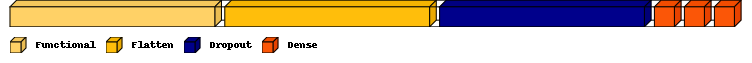

In [ ]:
from tensorflow.keras import layers
from collections import defaultdict
import tensorflow as tf
import visualkeras
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
color_map[layers.Dropout]['fill'] = '#00008B'
color_map[layers.BatchNormalization]['fill'] = '#FF1493'
visualkeras.layered_view(model, legend=True,color_map=color_map)

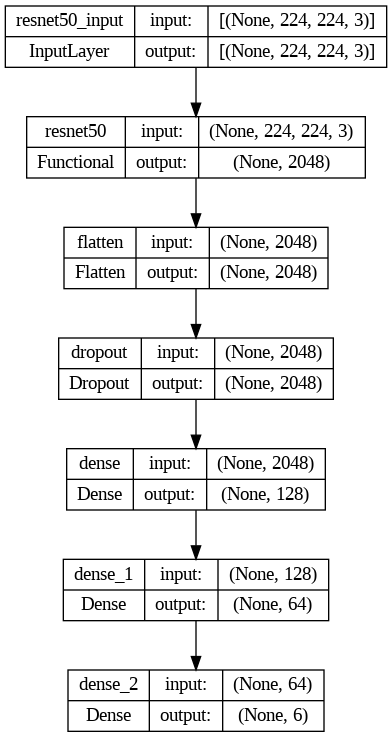

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',
            metrics=['accuracy',
                     'Precision',
                     'Recall',
                     tf.keras.metrics.AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False
                                    )])

In [ ]:

result=model.fit(
    x_train,
    steps_per_epoch=3072//32,
    validation_data=x_test,
    validation_steps=768//32,
    epochs=10,
    callbacks=[checkpoint]
)
# 10 epochs

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.9189 - accuracy: 0.7399 - precision: 0.7673 - recall: 0.7158 - auc: 0.8988
Epoch 1: val_accuracy improved from -inf to 0.78255, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 28s 132ms/step - loss: 0.9189 - accuracy: 0.7399 - precision: 0.7673 - recall: 0.7158 - auc: 0.8988 - val_loss: 0.7092 - val_accuracy: 0.7826 - val_precision: 0.8128 - val_recall: 0.7747 - val_auc: 0.9592
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.8187 - precision: 0.8416 - recall: 0.7956 - auc: 0.9527
Epoch 2: val_accuracy improved from 0.78255 to 0.85938, saving model to best_model.h5
96/96 [==============================] - 12s 120ms/step - loss: 0.6442 - accuracy: 0.8187 - precision: 0.8416 - recall: 0.7956 - auc: 0.9527 - val_loss: 0.4735 - val_accuracy: 0.8594 - val_precision: 0.9052 - val_recall: 0.8333 - val_auc: 0.9842
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.8499 - precision: 0.8916 - recall: 0.8353 - auc: 0.9743
Epoch 3: val_accuracy improved from 0.85938 to 0.86198, saving model to best_model.h5
96/96 [==============================] - 13s 1

# Check

In [ ]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(x_test, verbose=0)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.4f}%".format(results[1] * 100))
print("Test Precision: {:.4f}%".format(results[2] * 100))
print("   Test Recall: {:.4f}%".format(results[3] * 100))
print("      Test AUC: {:.4f}".format(results[4] ))

     Test Loss: 0.3616
 Test Accuracy: 90.4270%
Test Precision: 95.4438%
   Test Recall: 82.8662%
      Test AUC: 0.9921


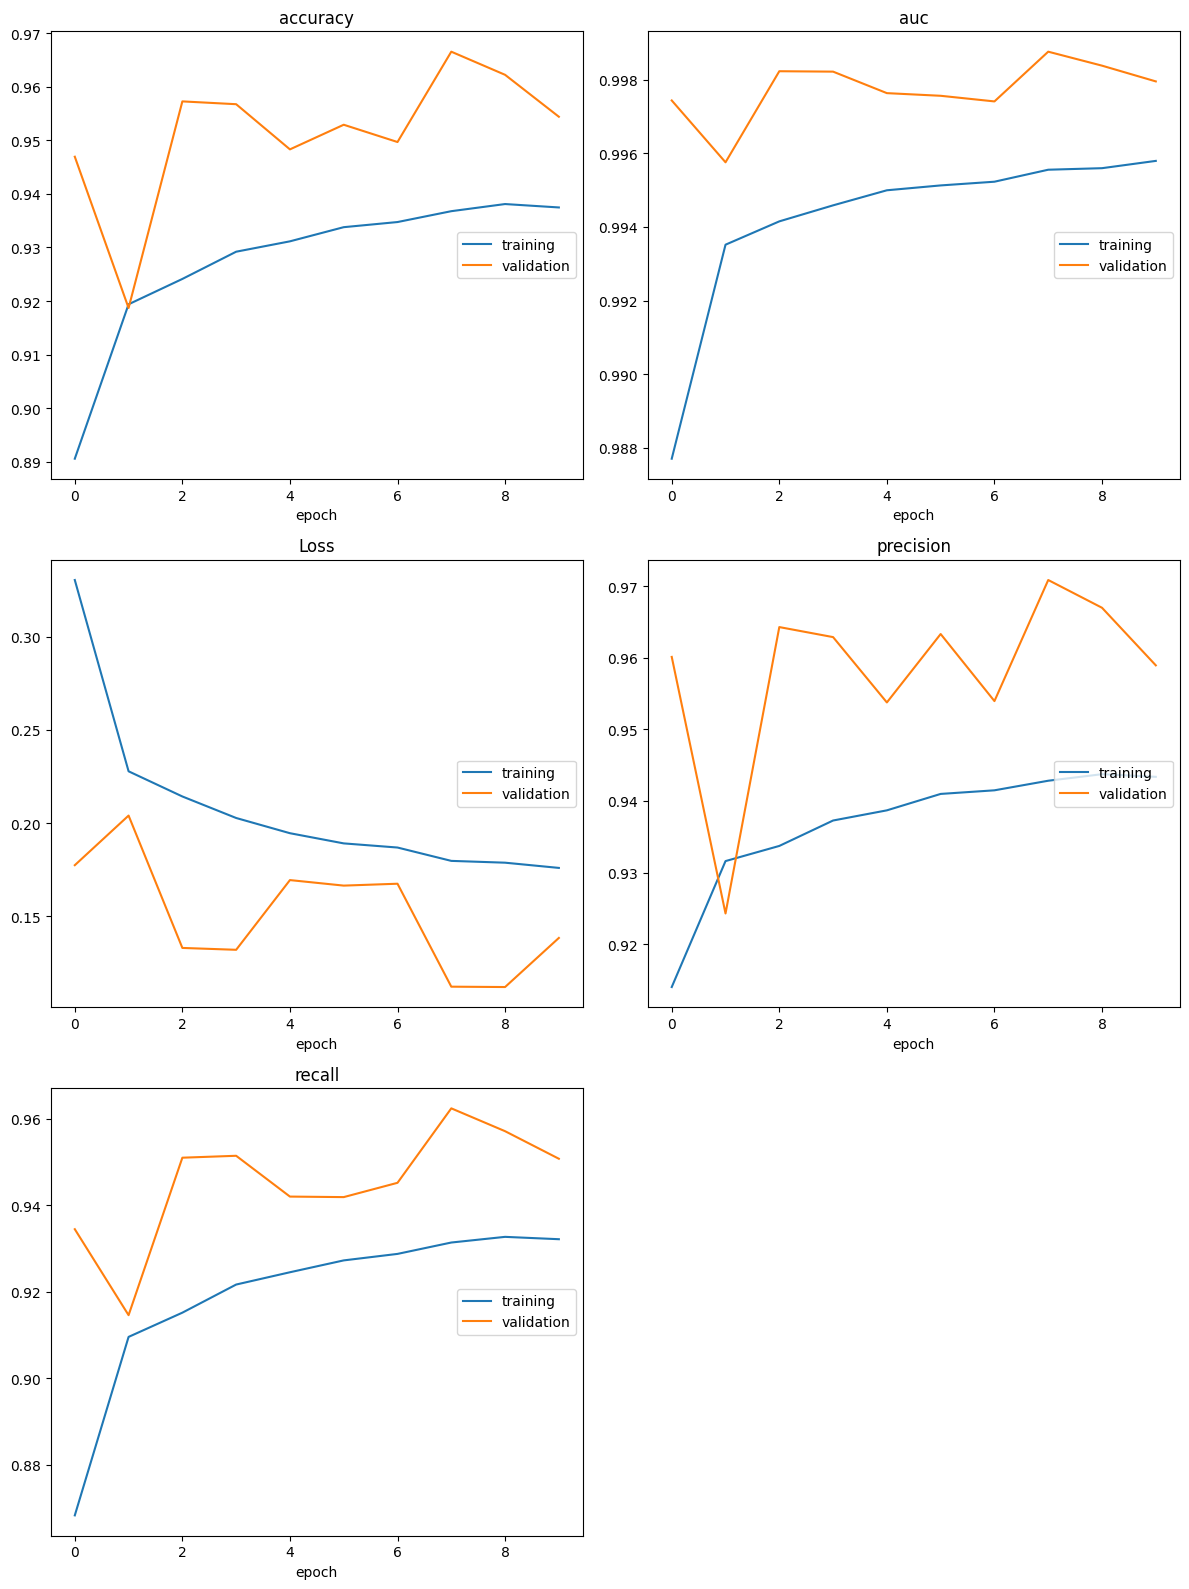

accuracy
	training         	 (min:    0.891, max:    0.938, cur:    0.937)
	validation       	 (min:    0.919, max:    0.967, cur:    0.954)
auc
	training         	 (min:    0.988, max:    0.996, cur:    0.996)
	validation       	 (min:    0.996, max:    0.999, cur:    0.998)
Loss
	training         	 (min:    0.176, max:    0.331, cur:    0.176)
	validation       	 (min:    0.112, max:    0.204, cur:    0.138)
precision
	training         	 (min:    0.914, max:    0.944, cur:    0.943)
	validation       	 (min:    0.924, max:    0.971, cur:    0.959)
recall
	training         	 (min:    0.868, max:    0.933, cur:    0.932)
	validation       	 (min:    0.915, max:    0.962, cur:    0.951)
3100/3100 [==============================] - 335s 108ms/step - loss: 0.1759 - accuracy: 0.9375 - precision: 0.9434 - recall: 0.9322 - auc: 0.9958 - val_loss: 0.1383 - val_accuracy: 0.9544 - val_precision: 0.9589 - val_recall: 0.9508 - val_auc: 0.9980 - lr: 0.0010


In [ ]:
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

# Define a scheduling function to reduce learning rate
def schedule(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * 0.1

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Modelcheckpoint definition
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Create a schedule to reduce learning rate
lr_scheduler = LearningRateScheduler(schedule)

history = model.fit_generator(generator=x_train, steps_per_epoch=len(x_train), epochs=10,
                              validation_data=x_test, validation_steps=len(x_test),
                              callbacks=[PlotLossesKeras(), lr_scheduler, early_stopping, model_checkpoint])


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


775/775 [==============================] - 73s 94ms/step - loss: 0.2636 - accuracy: 0.8999 - precision: 0.9230 - recall: 0.8795 - auc: 0.9933
Accuracy of the model on the test dataset: 89.99%
775/775 [==============================] - 70s 88ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.09      0.10      0.09      2101
           2       0.76      0.82      0.79     18926
           3       0.08      0.01      0.02      1608
           4       0.00      0.00      0.00       556
           5       0.06      0.06      0.06      1447

    accuracy                           0.64     24799
   macro avg       0.16      0.17      0.16     24799
weighted avg       0.60      0.64      0.62     24799



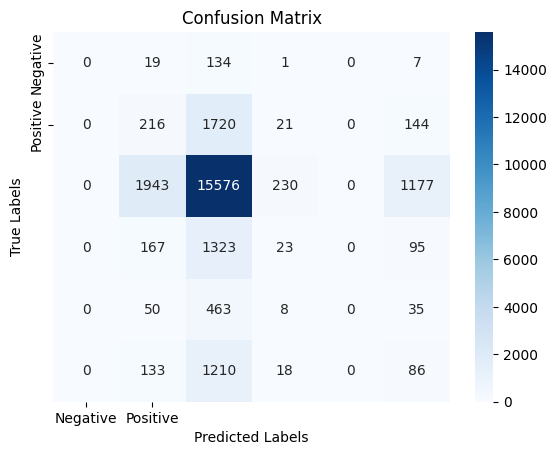

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def save_and_evaluate_model(model, model_path, x_test):
    # Save model
    model.save(model_path)

    # Evaluate the model on the test set
    evaluation_result = model.evaluate(x_test)
    accuracy = evaluation_result[1]
    print(f"Accuracy of the model on the test dataset: {accuracy:.2%}")

def calculate_metrics(y_true_labels, y_pred_labels):
    # Calculate evaluation indicators
    report = classification_report(y_true_labels, y_pred_labels)
    print(report)

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


save_and_evaluate_model(model, '/content/best_model.h5', x_test)

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = x_test.classes

calculate_metrics(y_true_labels, y_pred_labels)

1/1 [==============================] - 0s 78ms/step
Abnormal (2)


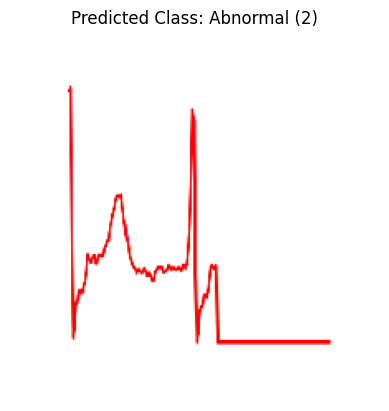

In [ ]:
from tensorflow.keras.preprocessing import image
def predict_image(model, image_path):
    # Dự đoán hình ảnh mới
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    y_pred = np.argmax(pred)

    index = ['Abnormal', 'Abnormal (1)', 'Abnormal (2)', 'Abnormal (3)', 'Abnormal (4)', 'Normal']
    result = str(index[y_pred])
    print(result)

    plt.imshow(img)
    plt.title(f'Predicted Class: {index[y_pred]}')
    plt.axis('off')
    plt.show()

predict_image(model, "/content/unknow_image.png")



In [ ]:
tf.keras.models.save_model(model,'my_model.h5')

evaluation_result = model.evaluate_generator(generator=x_test, steps=len(x_test))
accuracy = evaluation_result[1]
print(f"Accuracy of the model on the test dataset: {accuracy:.2%}")

y_pred = model.predict_generator(x_test, steps=len(x_test))
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = x_test.classes

TP = np.sum((y_true_labels == 1) & (y_pred_labels == 1))
FP = np.sum((y_true_labels == 0) & (y_pred_labels == 1))
TN = np.sum((y_true_labels == 0) & (y_pred_labels == 0))
FN = np.sum((y_true_labels == 1) & (y_pred_labels == 0))

precision = TP / (TP + FP)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)
print("Precision:", precision)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("F1 Score:", f1_score)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix = np.array([[7, 51], [90, 478]])

labels = ['Negative', 'Positive']

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

img=image.load_img("/content/drive/MyDrive/Unknown_image.png",target_size=(64,64))

x=image.img_to_array(img)

x=np.expand_dims(x,axis=0)

pred = model.predict(x)
y_pred=np.argmax(pred)
y_pred

index= ['Abnormal',
 'Abnormal (1)',
 'Abnormal (2)',
 'Abnormal (3)',
 'Abnormal (4)',
 'Normal']

result = str(index[y_pred])
result
